# Python Libraries

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from scipy import stats
import calendar
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import shap

%matplotlib inline

# Set Parameters

In [2]:
# Some parameters to use in the models later

testsize = 0.2
randomstate = 2020


# Random Forest Parameters
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=100, stop=500, num=5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num=5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

<b> Reading the Data <b/>

We have the dataset has more than 55M rows, therefore we can't import all of it. We will use read 8M rows in our project. 

In [3]:
train = pd.read_csv(
    'new-york-city-taxi-fare-prediction/train.csv', nrows=8000000)

# Data Exploration and Data Cleaning

## Data Cleaning 

In this section, we will look at the datasets closely. We will check if the datasets are missing any values. We will check if there are anomalies, clear outliers and format the dataset for visualization and model building. 

In [4]:
# First glance at the dataset

train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000000 entries, 0 to 7999999
Data columns (total 8 columns):
key                  object
fare_amount          float64
pickup_datetime      object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: float64(5), int64(1), object(2)
memory usage: 488.3+ MB


In [6]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,8.000000e+06,8.000000e+06,8.000000e+06,7.999951e+06,7.999951e+06,8.000000e+06
mean,1.133914e+01,-7.251302e+01,3.992341e+01,-7.251237e+01,3.992143e+01,1.684721e+00
std,9.807189e+00,1.289849e+01,9.122808e+00,1.285973e+01,9.311601e+00,1.324929e+00
min,-1.077500e+02,-3.439245e+03,-3.492264e+03,-3.412653e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399208e+01,4.073491e+01,-7.399139e+01,4.073404e+01,1.000000e+00
50%,8.500000e+00,-7.398182e+01,4.075263e+01,-7.398016e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396711e+01,4.076711e+01,-7.396368e+01,4.076811e+01,2.000000e+00
max,1.273310e+03,3.439426e+03,3.344459e+03,3.457622e+03,3.351403e+03,2.080000e+02


<p>Couple things we notice after first glance, key column seems unnecessary to keep since basically the same with pickup_datetime column. So we can remove it.<p/>

<p> Also, There are negative values on fare_amount column we need to remove.<p/>

<p> 

In [7]:
# Removing key column for the datasets

train = train.drop('key', axis=1)

In [8]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


Let's check if there is any missing data on the dataset. 

In [9]:
train.isnull().sum()

fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    49
dropoff_latitude     49
passenger_count       0
dtype: int64

There are 36 NAN in each dropoff_longitude and dropoff_latitude column. We will drop those NAN data.


In [10]:
train = train.dropna()

Let's check row number now. We removed 36 rows with NAN.

In [11]:
len(train)

7999951

<p>On the describe table, we saw that there are negative fare amount in the dataset. We will remove them as well.Also, we will remove the fare amount greater than $200 which I  believe it is the most expensive cab ride you can ever take in New York City.<p/>

<p> In NYC, initial charge is \$2.5 plus 50 cent surcharge is added to the fare at the end of the cab ride. Therefore, we will also remove the fare less than \$3 as well.

In [12]:
train = train[(train['fare_amount'] > 3) & (train['fare_amount'] < 200)]

Let's check our new row count

In [13]:
len(train)

7932680

By law, NYC taxi cabs are not allowed to carry more than four people. Therefore we will remove the data that has more passenger than four in passenger_count

In [14]:
train = train[(train['passenger_count'] < 5)]

In [15]:
len(train)

7202888

Wow, we removed more than four hundred thousand rows with passenger size more than four.

In [16]:
train = train[(train['pickup_longitude'] != train['dropoff_longitude']) & (
    train['pickup_latitude'] != train['dropoff_latitude'])]

Above, we also removed the rows that has the same pickup and drop off coordinates. 

In [17]:
len(train)

7003498

NY coordinates are ( 40.730610, -73.935242), so we will remove the coordinates that don't fall between these numbers. However we will apply this on only pickup coordinates since by law, NYC cabs can drop off passengers to other states, but can only pick them up from NY. We want to include the rides that were picked up from New York to close states like New Jersey, Connecticut and Pennsylvania.

In [18]:
train = train[train['pickup_latitude'].between(40, 41)]
train = train[train['pickup_longitude'].between(-74, -73)]

In [19]:
train.shape

(6045217, 7)

## Feature Engineering

We will convert pickup_datetime column to datetime, then we can use hour,day and year in our prediction models. 

In [22]:
# Converting to datetime

train['pickup_datetime'] = pd.to_datetime(
    train['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC')

In [23]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1
6,7.5,2012-11-20 20:35:00,-73.980002,40.751662,-73.973802,40.764842,1


In [24]:
# adding hour, day, day of the week, month and year columns
train['pickup_day'] = train['pickup_datetime'].apply(lambda x: x.day)
train['pickup_hour'] = train['pickup_datetime'].apply(lambda x: x.hour)
train['pickup_day_of_week'] = train['pickup_datetime'].apply(
    lambda x: calendar.day_name[x.weekday()])
train['pickup_month'] = train['pickup_datetime'].apply(lambda x: x.month)
train['pickup_year'] = train['pickup_datetime'].apply(lambda x: x.year)

We will calculate the absolute difference between longitude and latitude coordinates, and we will add new columns with the calculated coordinates differences. This is not the actual difference in miles/km but it gives us a good idea to compare distances for each ride. 

In [25]:
train['latitude_difference'] = (
    train['dropoff_latitude'] - train['pickup_latitude']).abs()
train['longitude_difference'] = (
    train['dropoff_longitude'] - train['pickup_longitude']).abs()

In [26]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year,latitude_difference,longitude_difference
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,15,17,Monday,6,2009,0.009041,0.002701
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,18,0,Thursday,8,2011,0.010708,0.008504
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,21,4,Saturday,4,2012,0.024949,0.004437
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,9,7,Tuesday,3,2010,0.015754,0.011440
6,7.5,2012-11-20 20:35:00,-73.980002,40.751662,-73.973802,40.764842,1,20,20,Tuesday,11,2012,0.013180,0.006200


We will measure the distance for each cab ride by using __Haversine distance formula__. Haversine distance measures the distance between two points by using coordinates and taking into account the spherical shape of the Earth. The code below to calculate Haversine distance is from a Stack Overflow answer that you can see the link in comments:

In [27]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    source: https://stackoverflow.com/a/29546836

    """
    # Convert latitude and longitude to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Find the differences
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Apply the formula
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    # Calculate the angle (in radians)
    c = 2 * np.arcsin(np.sqrt(a))
    # Convert to kilometers
    radius = 6371.01

    km = radius * c

    return km

In [28]:
train['distance_in_km'] = haversine_np(train['pickup_longitude'], train['pickup_latitude'],
                                       train['dropoff_longitude'], train['dropoff_latitude'])

In [29]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year,latitude_difference,longitude_difference,distance_in_km
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,15,17,Monday,6,2009,0.009041,0.002701,1.030766
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,18,0,Thursday,8,2011,0.010708,0.008504,1.389527
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,21,4,Saturday,4,2012,0.024949,0.004437,2.799275
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,9,7,Tuesday,3,2010,0.015754,0.011440,1.999160
6,7.5,2012-11-20 20:35:00,-73.980002,40.751662,-73.973802,40.764842,1,20,20,Tuesday,11,2012,0.013180,0.006200,1.555809


The longest ride should not be more than 150 km in NYC even considering the rides picked up from the city to close states like NJ or PA.Thus, we should remove the rides longer than 150 km. 

In [30]:
train = train[train["distance_in_km"] < 150]

In [31]:
train.shape

(6040213, 15)

## Data Visualization

We will create some plots to see the correlation between the features and the target, and we will answer some questions that will help exploring the data and make meaningful predictions later on.

__Fare Amount Distribution__

Text(0.5, 0, 'Fare Amount')

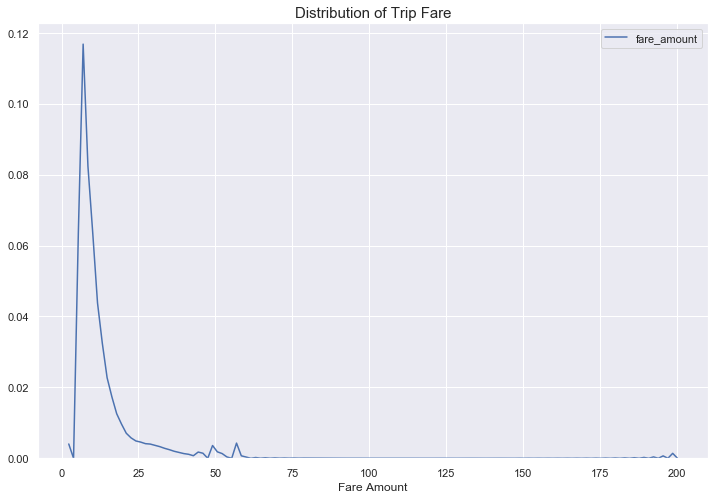

In [32]:
sns.set()
plt.figure(figsize=(12, 8))
sns.kdeplot(train['fare_amount']).set_title(
    "Distribution of Trip Fare", fontsize=15)
plt.xlabel('Fare Amount')

Most of the rides cost less than 25 dollars, average fare amount is \\$11.36 and median is \\$8.5

__Trip Distance vs. Fare Amount__

We will check the relationship between trip distance and fare amount. It should be linear relationship between them, we will create a plot and see if it does.

Text(0, 0.5, 'Fare Amount')

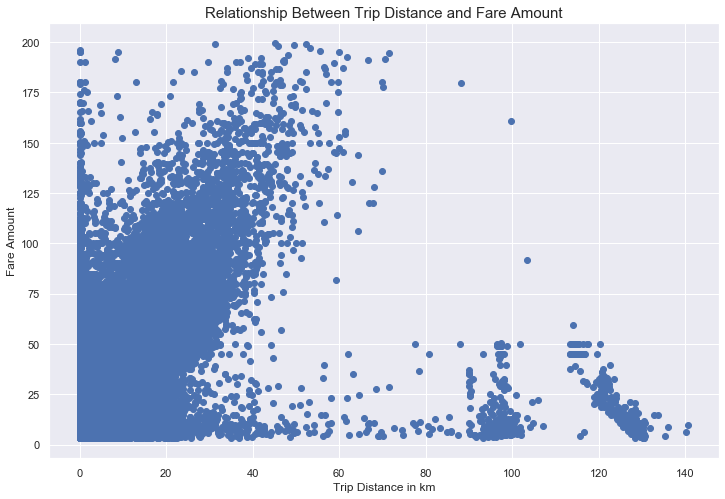

In [33]:
sns.set()
plt.figure(figsize=(12, 8))
plt.scatter(train.distance_in_km, train.fare_amount)
plt.title("Relationship Between Trip Distance and Fare Amount", fontsize=15)
plt.xlabel('Trip Distance in km')
plt.ylabel('Fare Amount')

As we expected, fare amount increases with the distance traveled for the most of the rides. There is a good amount of the rides with longer distance and less than \$50. It could be the airport rides since there is a flat rate policy to/from NY airports.

<p> However, there are good amount of rides that don't make much sense on the upper left corner ( very short distance and higher than $100), we will remove those rides as well. <p/>

<p> Also, we want to remove the rides takes more than 50 km and cost less than $10.

In [34]:
# removing the ride cost more $100 with less than 1 km
c = train[(train.distance_in_km < 1) & (train.fare_amount > 100)]
train = train.drop(c.index)
d = train[(train.distance_in_km > 50) & (train.fare_amount < 10)]
train = train.drop(d.index)

In [35]:
train.shape

(6039637, 15)

Text(0, 0.5, 'Fare Amount')

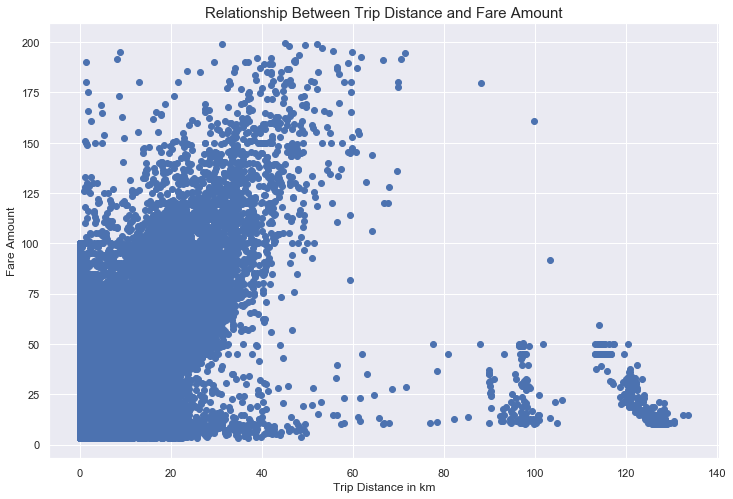

In [36]:
# Let's plot again!
sns.set()
plt.figure(figsize=(12, 8))
plt.scatter(train.distance_in_km, train.fare_amount)
plt.title("Relationship Between Trip Distance and Fare Amount", fontsize=15)
plt.xlabel('Trip Distance in km')
plt.ylabel('Fare Amount')

__Passenger Number vs. Fare Amount__

We want to investigate if there is a correlation between passenger number and fare amount. Also, we can check the passanger number for the most of the cab ride. Let's start creating our plots.

Text(0, 0.5, 'Frequency')

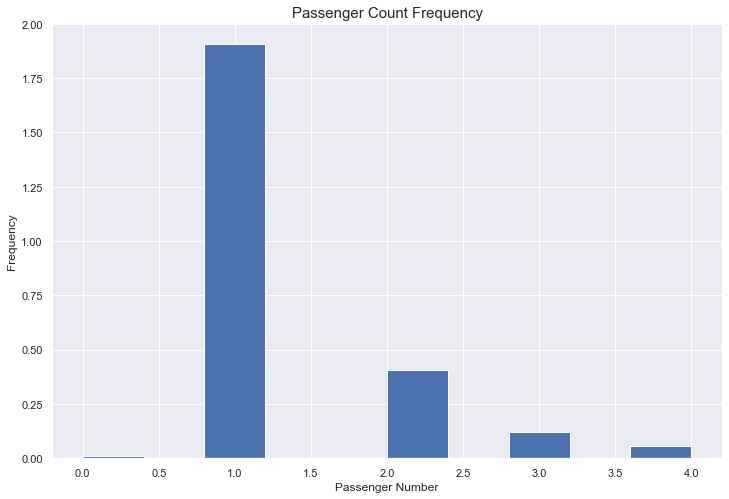

In [37]:
sns.set()
plt.figure(figsize=(12, 8))
plt.hist(train.passenger_count, density=True, bins=10)
plt.title("Passenger Count Frequency", fontsize=15)
plt.xlabel('Passenger Number')
plt.ylabel('Frequency')

Most of the rides is with one passenger, we can see a small amount of rides with no passengers. This needs further investigation. 

In [38]:
# Checking if there is any rides without any passenger
train[train.passenger_count == 0].shape

(23639, 15)

There are 23639 rides with no passenger in our dataset. We will remove these rides because rides without passenger is not a cab ride at all! 

In [39]:
train = train[train.passenger_count != 0]

Text(0, 0.5, 'Frequency')

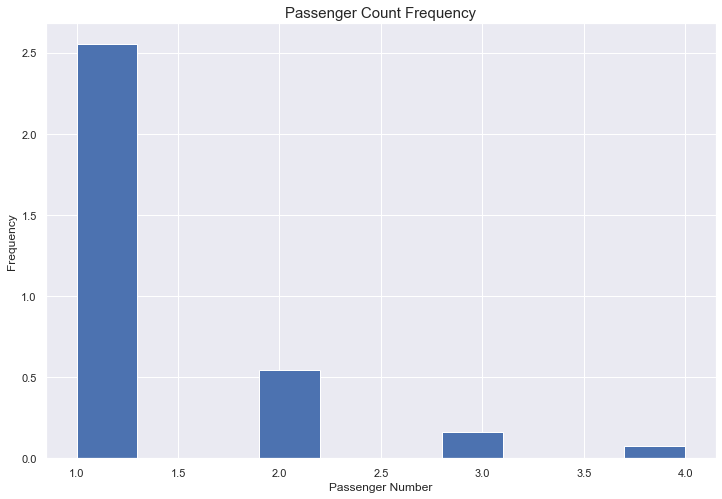

In [40]:
# Now
sns.set()
plt.figure(figsize=(12, 8))
plt.hist(train.passenger_count, density=True, bins=10)
plt.title("Passenger Count Frequency", fontsize=15)
plt.xlabel('Passenger Number')
plt.ylabel('Frequency')

Our plot looks better now, 1 passenger is the most frequent and 4 passenger is least frequent.

Text(0, 0.5, 'Fare Amount')

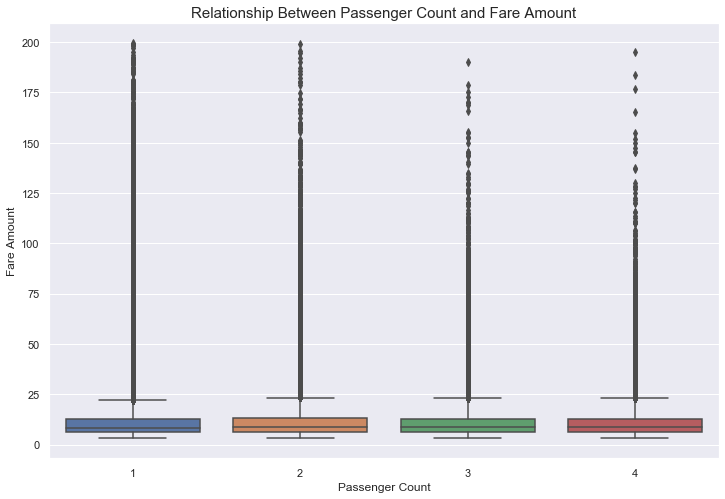

In [41]:
# Creating plot showing correlation between passenger count and fare amount
sns.set()
plt.figure(figsize=(12, 8))
sns.boxplot(train.passenger_count, train.fare_amount)
plt.title("Relationship Between Passenger Count and Fare Amount", fontsize=15)
plt.xlabel('Passenger Count')
plt.ylabel('Fare Amount')

The box for each passenger count look similar, they have same median and whiskers. That makes us think that fare amount and passenger count is not correlated much. We can check the correlation between them.

In [42]:
train[['fare_amount', 'passenger_count']].corr()

,fare_amount,passenger_count
fare_amount,1.000000,0.022614
passenger_count,0.022614,1.000000


As we suspected, there is little correlation between passenger count and fare amount. We will take this into consideration we build our models.

__Pick up Hour vs. Fare Amount__

We will create plots to check if the fare amount changes depends on the time, date, month or the year. Let's start with time, we will check if there is a pattern we can see.

Text(0, 0.5, 'Average Fare Amount')

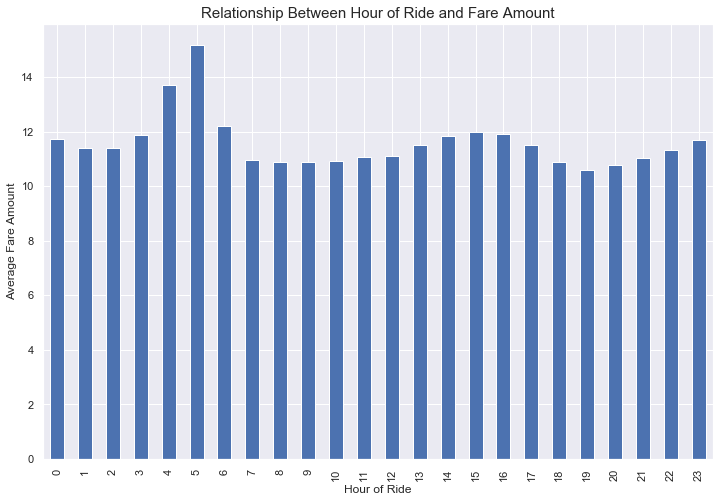

In [43]:
sns.set()
plt.figure(figsize=(12, 8))
train.groupby('pickup_hour')['fare_amount'].mean().plot.bar()
plt.title("Relationship Between Hour of Ride and Fare Amount", fontsize=15)
plt.xlabel('Hour of Ride')
plt.ylabel('Average Fare Amount')

Average fare amount is similar expect the rides take place at 4 AM and 5 AM. Average rate is the highest at 5 AM.


Text(0, 0.5, 'Total Ride Amount')

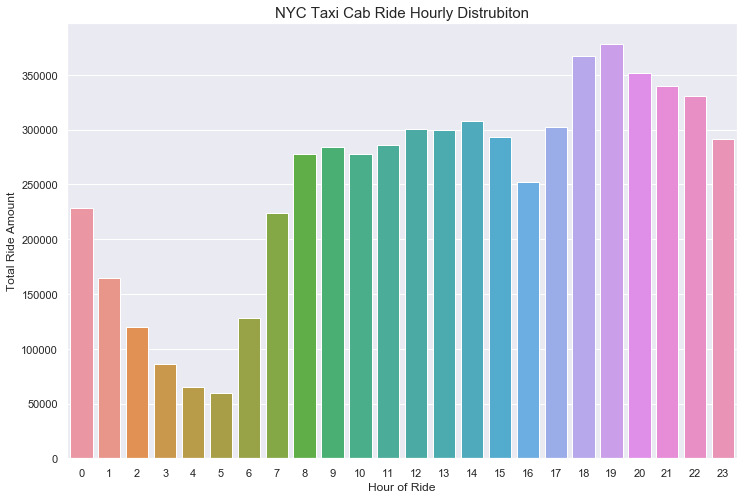

In [44]:
sns.set()
plt.figure(figsize=(12, 8))
sns.countplot('pickup_hour', data=train)
plt.title('NYC Taxi Cab Ride Hourly Distrubiton', fontsize=15)
plt.xlabel('Hour of Ride')
plt.ylabel('Total Ride Amount')

The least busy time of the day for the taxi cabs in NYC is 4 AM and 5 AM, the busiest time is between 6 PM to 7 PM which makes sense since it is rush hour. The amount of the rides increases from morning till 7 PM, then it decreases till it reaches the lowest level at 7 AM.

__Pick Up Day vs. Fare Amount__

Text(0, 0.5, 'Total Ride Amount')

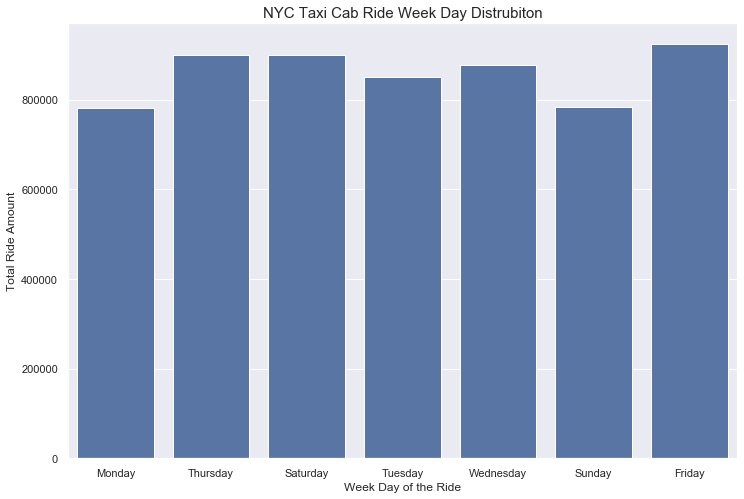

In [45]:
sns.set()
plt.figure(figsize=(12, 8))
sns.countplot('pickup_day_of_week', data=train, color='b')
plt.title('NYC Taxi Cab Ride Week Day Distrubiton', fontsize=15)
plt.xlabel('Week Day of the Ride')
plt.ylabel('Total Ride Amount')

Sundays and Mondays are the least busiest days of the week. Total amount of the rides increases from Monday through Friday. Friday is the busiest day.

Text(0, 0.5, 'Average Fare Amount')

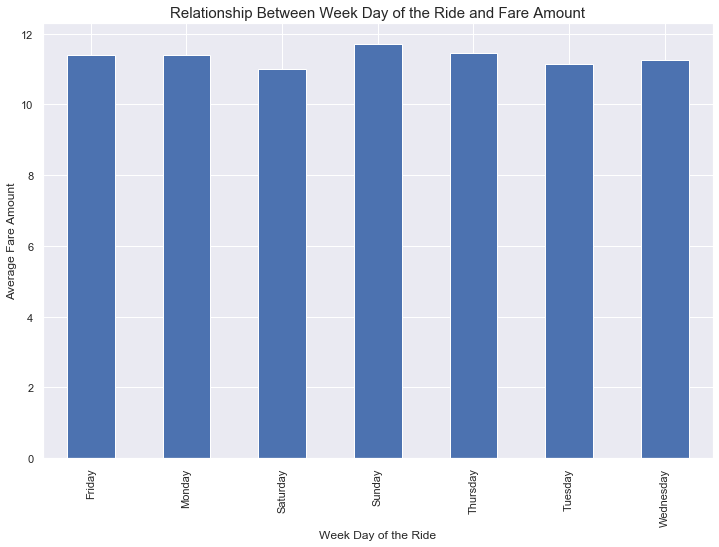

In [46]:
sns.set()
plt.figure(figsize=(12, 8))
train.groupby('pickup_day_of_week')['fare_amount'].mean().plot.bar()
plt.title("Relationship Between Week Day of the Ride and Fare Amount", fontsize=15)
plt.xlabel('Week Day of the Ride')
plt.ylabel('Average Fare Amount')

There is not much difference on average fare amount for any week day.

Text(0, 0.5, 'Total Ride Amount')

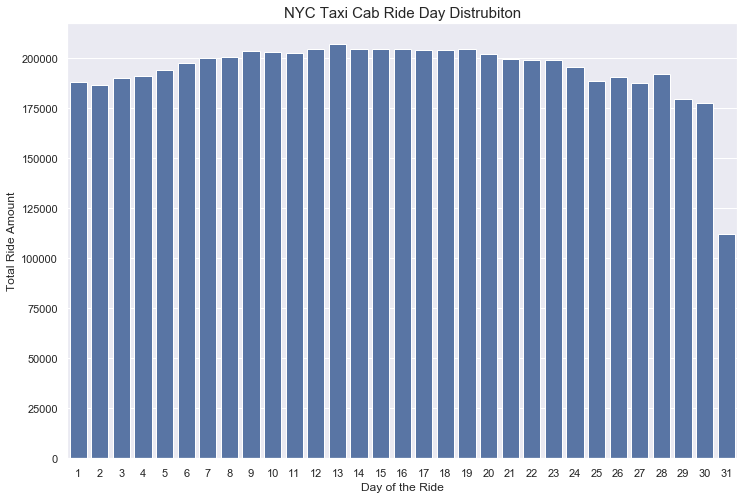

In [47]:
sns.set()
plt.figure(figsize=(12, 8))
sns.countplot('pickup_day', data=train, color='b')
plt.title('NYC Taxi Cab Ride Day Distrubiton', fontsize=15)
plt.xlabel('Day of the Ride')
plt.ylabel('Total Ride Amount')

The ride amount goes up from first day of the month till 20th day of the month, then goes down and hits the lowest on the last day of the month.

Text(0, 0.5, 'Average Fare Amount')

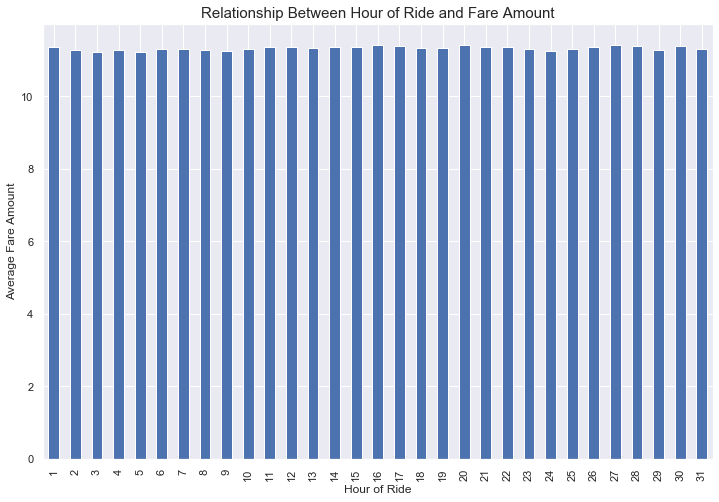

In [48]:
sns.set()
plt.figure(figsize=(12, 8))
train.groupby('pickup_day')['fare_amount'].mean().plot.bar()
plt.title("Relationship Between Hour of Ride and Fare Amount", fontsize=15)
plt.xlabel('Hour of Ride')
plt.ylabel('Average Fare Amount')

There is not much difference on the average fare amount on the days of the month as the plot shows us.

__Pick Up Month vs. Fare Amount__

([<matplotlib.axis.XTick at 0x7fda30dbfb90>,
 <a list of 12 Text xticklabel objects>)

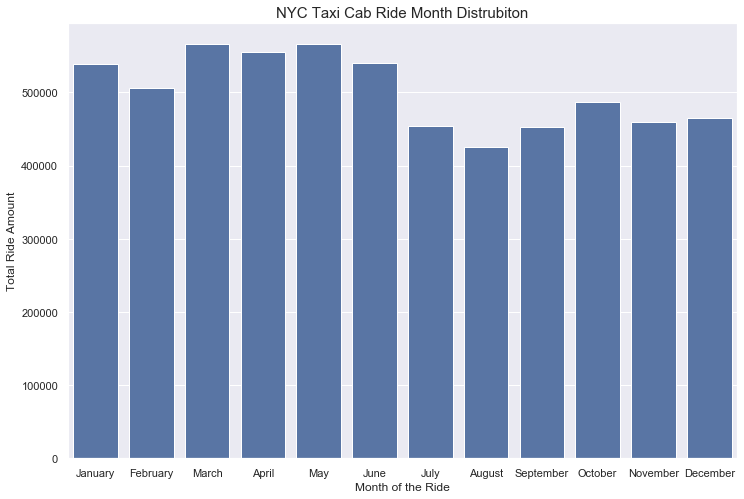

In [49]:
sns.set()
ticks = ['January', 'February', 'March', 'April', 'May', 'June',
         'July', 'August', 'September', 'October', 'November', 'December']
plt.figure(figsize=(12, 8))
sns.countplot('pickup_month', data=train, color='b')
plt.title('NYC Taxi Cab Ride Month Distrubiton', fontsize=15)
plt.xlabel('Month of the Ride')
plt.ylabel('Total Ride Amount')
plt.xticks(np.arange(0, 12), ticks)

The ride amounts hits the lowest in July and August. This makes sense because NYC gets empty during summer. And the busiest season is Spring (March, April, May).

([<matplotlib.axis.XTick at 0x7fda30a91d50>,
 <a list of 12 Text xticklabel objects>)

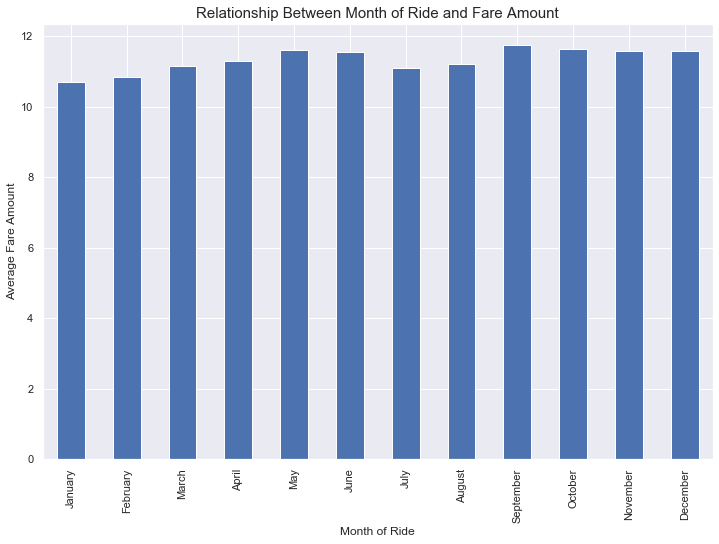

In [50]:
sns.set()
plt.figure(figsize=(12, 8))
train.groupby('pickup_month')['fare_amount'].mean().plot.bar()
plt.title("Relationship Between Month of Ride and Fare Amount", fontsize=15)
plt.xlabel('Month of Ride')
plt.ylabel('Average Fare Amount')
plt.xticks(np.arange(0, 12), ticks)

The average fare amount is a little lower in January, the rest of the months has similar average fare amount. 

__Pick Up Year vs. Fare Amount__

Text(0, 0.5, 'Total Ride Amount')

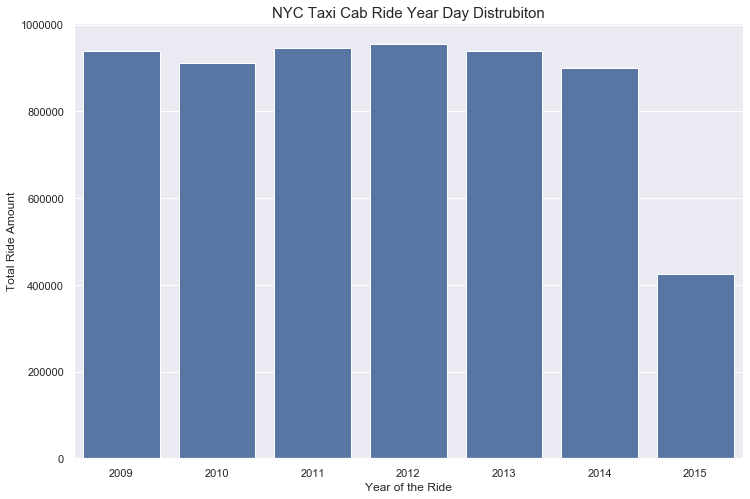

In [51]:
sns.set()
plt.figure(figsize=(12, 8))
sns.countplot('pickup_year', data=train, color='b')
plt.title('NYC Taxi Cab Ride Year Day Distrubiton', fontsize=15)
plt.xlabel('Year of the Ride')
plt.ylabel('Total Ride Amount')

For some reason, 2015 ride amount is less then half from other years. 

Text(0, 0.5, 'Average Fare Amount')

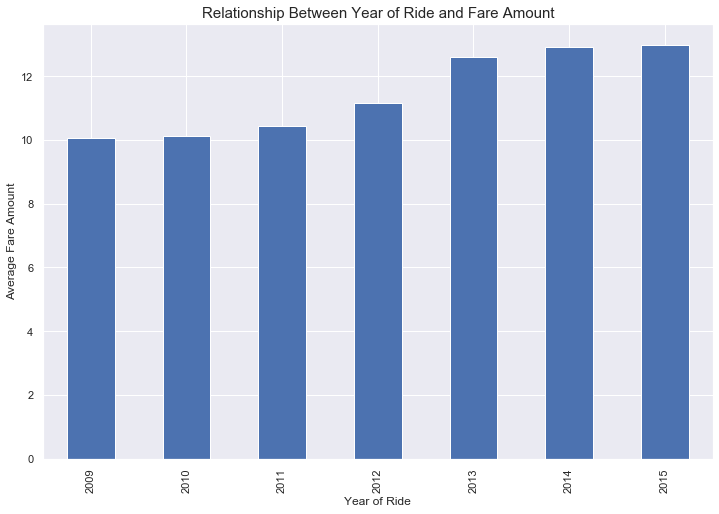

In [52]:
sns.set()
plt.figure(figsize=(12, 8))
train.groupby('pickup_year')['fare_amount'].mean().plot.bar()
plt.title("Relationship Between Year of Ride and Fare Amount", fontsize=15)
plt.xlabel('Year of Ride')
plt.ylabel('Average Fare Amount')

The average fare amount increases by the year significantly.

__Correlation with Fare Amount__

Finally, we can create a plot to see the correlation between the features and the fare amount. The correlation coefficient measures the strength and direction of a linear relationship. 

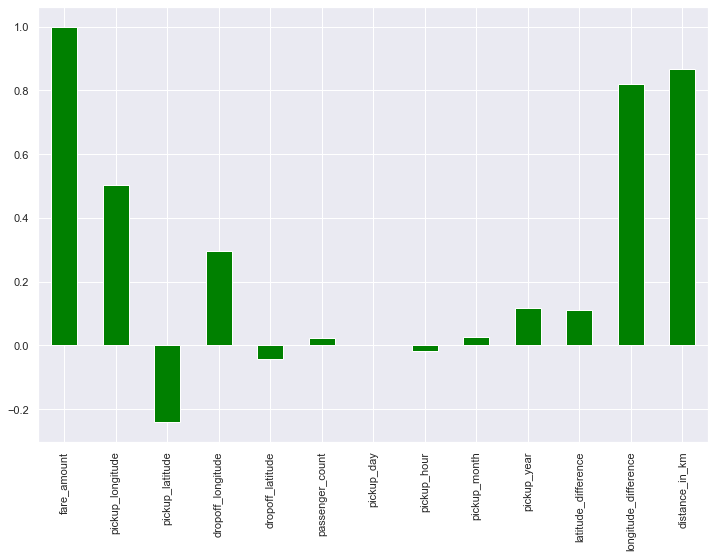

In [53]:
corrs = train.corr()
sns.set()
plt.figure(figsize=(12, 8))
corrs['fare_amount'].plot.bar(color='green')

Distance has positive linear relationship with fare amount. When distance increases fare amount increases as well. It seems like date time features expect pick up year doesn't have a strong relationship with the fare amount. 

Let's check the correlation heatmap as well:

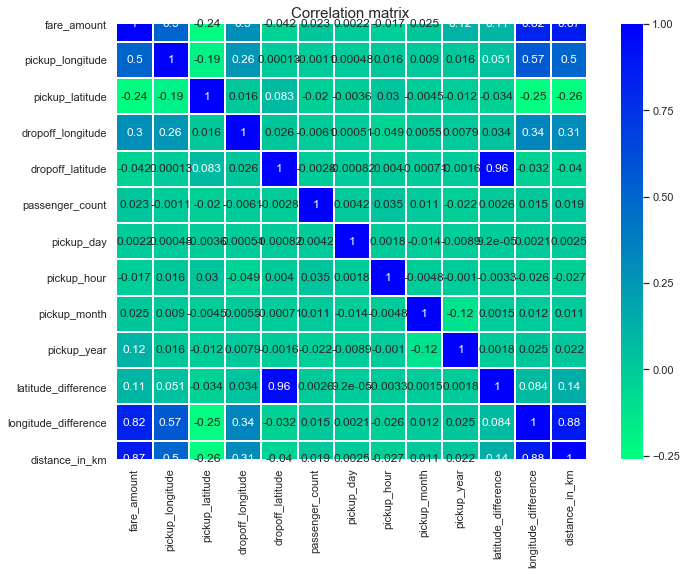

In [54]:
sns.set()
plt.figure(figsize=(12, 8))
sns.heatmap(corrs, square=True, cmap='winter_r',
            linewidths=1, linecolor='w', annot=True)
plt.title('Correlation matrix ', fontsize=15)
plt.show()

# Machine Learning

Now, we will start building our models to predict the fare amount with our dataset. We will start with the simple algorithm, we will try to improve our accuracy by training more complex models with different features and tuning. We will start with Linear Regression since there is a strong linear correlation between some features and fare amount.  

## Linear Regression 

First, we will start with simple Linear Regression Model with the some features and check our scores. Then, we will try to improve our scores. 

In [55]:
lr = LinearRegression()

__Split Dataset into Training and Test__

We will set our prediction features (__X__) and target(__y__), then we will split our dataset into training and test. We will split training as 80% and test as 20% since we have big enough dataset. We will also drop non numeric columns like pickup_datetime and pickup_day_of_week as well.

In [56]:
# setting up X and y
X = train.drop(['fare_amount', 'pickup_datetime',
                'pickup_day_of_week'], axis=1)
y = train['fare_amount']

In [57]:
# splitting out train and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=testsize, random_state=randomstate)

__Fitting the Model__

First, We will fit features that are high correlated with fare amount and not correlated with each other.

In [58]:
# Training the train data
selected_features = ['pickup_year', 'distance_in_km', 'longitude_difference']

lr.fit(X_train[selected_features], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

__Model Score__

We will measure our models accuracy by using __Root mean squared error (RMSE)__. RMSE is the square root of the average of squared differences between prediction and actual observation. It is one of the most common metrics used in measuring continuous variables. Since RMSE shows the error of the prediction, lower score is better.

In [59]:
# defining RMSE
def rmse(features, model):

    model.fit(X_train[features][:100000], y_train[:100000])
    predict = model.predict(X_test[features])

    print('RMSE of Model Regression: %.3f' %
          np.sqrt(mean_squared_error(y_test, predict)))

In [60]:
rmse(selected_features, lr)

RMSE of Model Regression: 4.515


We have a first RMSE score, we will add more features and see if we can get better score than 4.515

In [61]:
# Fitting all features to the model
rmse(X.columns, lr)

RMSE of Model Regression: 4.488


Second RMSE score is 4.488 with all features. There are couple more things we can try to improve our score. Since we can't tune any parameters in simple Linear Regression, we can add more variables/observations. Also, we can work building new features. Last, we can try more complex models to get better RMSE score. 

## Random Forest Regression

Next, we will try Random Forest Regression to try to get a better RMSE score with our dataset. Random forest is a good algorithm to avoid overfitting problem and it can be tuned to get better scores even it's default hyperparameters return pretty good results.

In [120]:
# building the model
rf = RandomForestRegressor()

First, we will use sklearn default random forest hyperparametres, we will not tune it. Since this is a very large dataset,we will only use first 50K rows to train the model to save time on computation. 

In [63]:
# Fitting data on model
rf.fit(X_train[:50000], y_train[:50000])

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [121]:
# Redefining our score method to save time
def rmse(features, model):

    model.fit(X_train[features][:50_000], y_train[:50_000])
    predict = model.predict(X_test[features][:50_000])

    print('RMSE of Model Regression: %.3f' %
          np.sqrt(mean_squared_error(y_test[:50_000], predict)))

In [122]:
# First RMSE score with Random Forest
rmse(X.columns, rf)

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


RMSE of Model Regression: 3.647


<p> Our RMSE score with Random Forest is way better than what we have with Linear Regression. This explains our dataset fits better on non-linear algorithms. <p/>

<p> We can try couple things to get even better score with Random Forest. We can use cross validation and grid search to tune the hyperparameters and get the best combination tried in different folds. <p/>

<p> We will adjust some of the most important parameters in Random Forest algorithm such number of trees used in the model, max number of levels in each decision tree and such.

In [66]:
# Create the random grid
parameters = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

In [67]:
# using GridSearch in 3 fold to find the best parameters
rf_grid = GridSearchCV(estimator=rf, param_grid=parameters,
                       cv=3, n_jobs=-1, verbose=2)

In [68]:
# Fit the grid search to the dataset
# rf_grid.fit(X_train[:50000], y_train[:50000])

It takes too much time to compute above line, therefore we will commend it out since we already learnt the best parameters for our model.

In [123]:
rf = RandomForestRegressor(bootstrap=True, max_depth=80, max_features=3,
                           min_samples_leaf=5, min_samples_split=12, n_estimators=100)

In [124]:
# Checkign score again with best parameters
rmse(X.columns, rf)

RMSE of Model Regression: 3.470


In [125]:
print(' Increase of RMSE score after GridSearch: %.3f percent' %
      np.abs(100 * (3.470 - 3.647) / 3.647))

 Increase of RMSE score after GridSearch: 4.853 percent


<p>We increased RMSE score 4.8% by using GridSearch to find the best parameters and using them in the model. Idea to improve RMSE: we only fitted the first 50K rows to our model. We can fit more rows to get better score even though it takes more time to compute.<p/> Let's check the most important features for Random Forest Model.

In [126]:
# Creating feature important dataframe
rf_feature_importance = pd.DataFrame(
    {'Feature': X_train.columns, 'Importance': rf.feature_importances_}).sort_values('Importance', ascending=False)

In [127]:
rf_feature_importance

,Feature,Importance
11,distance_in_km,0.307435
10,longitude_difference,0.295595
9,latitude_difference,0.152224
0,pickup_longitude,0.078751
2,dropoff_longitude,0.060995
1,pickup_latitude,0.037075
3,dropoff_latitude,0.034600
8,pickup_year,0.018547
6,pickup_hour,0.006424
7,pickup_month,0.003933


Text(0, 0.5, 'Feature')

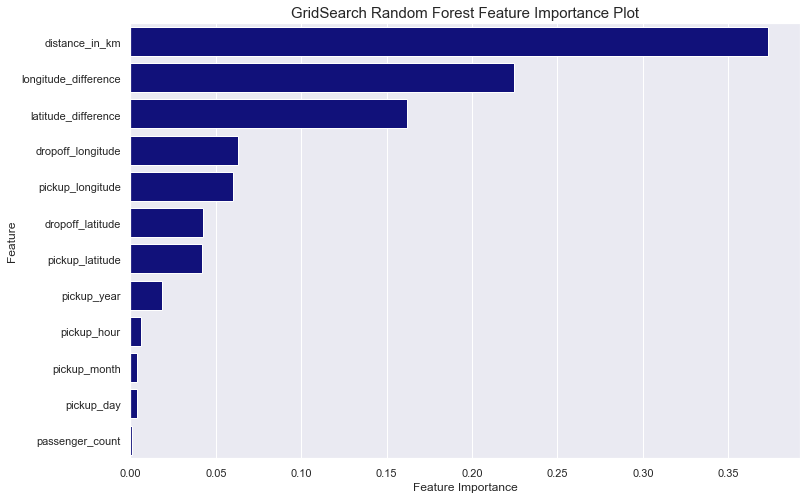

In [93]:
sns.set()
plt.figure(figsize=(12, 8))
sns.barplot(x=rf_feature_importance['Importance'],
            y=rf_feature_importance['Feature'], color='darkblue')
plt.title("GridSearch Random Forest Feature Importance Plot", fontsize=15)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')

<p>Most important feature for random forest is distance_in_km, and there are some feature variables that are not important for the model. <p/>

<p>Ideas to Improve: Since the distance is the most important feature for this model, we can look into using a different distance measurement ( euclidean or manhattant) to improve score. Also, we can remove the features that has little or no importance to improve the score. Last, we can try some other complex algorithms to see if we can score better RMSE score. <p/>

## XGBoost Regression

Xgboost regression algorithm is one of the most popular algorithms in the modern machine learning world due to its computing speed and performance. We will try our dataset on this algorithm since our data fits better on non-linear complex algorithms.

In [131]:
# building the model
xgb = XGBRegressor()

In [132]:
# First RMSE score with XGboost
rmse(X.columns, xgb)

RMSE of Model Regression: 3.404


We got our best RMSE score so far with XGBoost with using default parameters. That's good start! Now, we will tune the hyperparameters to improve RMSE score. Again, we will use GridSearch to find the best parameters as we did for Random Forest model.

In [133]:
# setting grid parameters
xgb_parameter = {'learning_rate': [0.07, 0.1, 0.3],
                 'max_depth': [3, 5, 7],
                 'n_estimators': [200, 400, 500]}

In [105]:
# using GridSearch in 3 fold to find the best parameters
xgb_grid = GridSearchCV(estimator=xgb, param_grid=xgb_parameter,
                        cv=3, n_jobs=-1, verbose=2)

In [106]:
# Commend below out since it takes so much to compute
# xgb_grid.fit(X_train[:50000], y_train[:50000])

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 10.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estim...
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', validate_parameters=1,
                                  

In [134]:
print(xgb_grid.best_params_)

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 400}


In [135]:
# building the model with best parameter
xgb = XGBRegressor(learning_rate=0.1, max_depth=7, n_estimators=400)

In [136]:
# Checking score again with best parameters
rmse(X.columns, xgb)

RMSE of Model Regression: 3.371


<p> As we guessed, we improved RMSE good amount by tuning the parameters. <p/>
Idea to improve: Since we improved RMSE with parameter tuning with GridSearch, there are more hyperparameters can be tuned such as colsample_bytree,gamma. We can add these parameters to Gridsearch (or RandomSearch) to improve RMSE.

In [137]:
# Creating feature important dataframe for Xgboost
xgb_feature_importance = pd.DataFrame(
    {'Feature': X_train.columns, 'Importance': xgb.feature_importances_}).sort_values('Importance', ascending=False)

Text(0, 0.5, 'Feature')

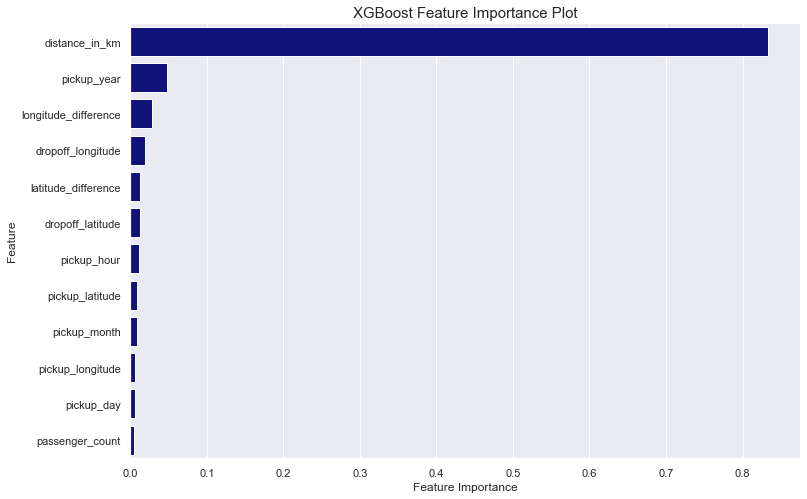

In [138]:
sns.set()
plt.figure(figsize=(12, 8))
sns.barplot(x=xgb_feature_importance['Importance'],
            y=xgb_feature_importance['Feature'], color='darkblue')
plt.title("XGBoost Feature Importance Plot", fontsize=15)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')

One and only important feature here is distance in km. Therefore, trying different measurement calculations using coordinates may make significant difference on this model's prediction power.

## LightGBM Regression

The last algorithm we will try on our dataset is LightGBM Regression algorithm.  Since LightGBM can handle the large size of data and takes lower memory to run, it will be a good option for our dataset.

In [141]:
# building the model
import lightgbm
lightgb = lgb.LGBMRegressor(objective='regression', metric='mse')

First, we will fit the data with default parameters and check the RMSE score. 

In [143]:
# First RMSE score with LGBM
rmse(X.columns, lightgb)

RMSE of Model Regression: 3.413


First RMSE score is little higher from what we achieve with XGBoost. We can tune the hyperparameters with GridSearch for LightGBM for improving the first score.

In [162]:
param_grid = {
    'n_estimators': [400, 700, 1000],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15, 20, 25],
    'num_leaves': [50, 100, 200],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'min_split_gain': [0.3, 0.4],
    'subsample': [0.7, 0.8, 0.9],
    'subsample_freq': [20]
}

In [164]:
# using GridSearch in 3 fold to find the best parameters
light_grid = GridSearchCV(estimator=lightgb, param_grid=param_grid,
                          cv=3, n_jobs=-1, verbose=2)

In [165]:
# Commend below out since it takes so much to compute
#light_grid.fit(X_train[:50000], y_train[:50000])

Fitting 3 folds for each of 2916 candidates, totalling 8748 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 34.9min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 73.6min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 178.7min


KeyboardInterrupt: 

In [166]:
# printing best parameters for LightGBM
print(light_grid.best_params_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [175]:
# building the model with best parameter
lightgb = lgb.LGBMRegressor(objective='regression', metric='mse',
                            learning_rate=0.07, boosting_type='gbdt', n_estimators=400, max_depth=15, min_split_gain=0.3,
                            num_leaves=50, reg_alpha=1.3, reg_lambda=1.1, subsample=0.7, subsample_freq=20, colsample_bytree=0.7)

In [176]:
# 2nd score with LightGBM with best parameter
rmse(X.columns, lightgb)

RMSE of Model Regression: 3.408


In [177]:
# Creating feature important dataframe for Light GBM
lightgb_feature_importance = pd.DataFrame(
    {'Feature': X_train.columns, 'Importance': lightgb.feature_importances_}).sort_values('Importance', ascending=False)

Text(0, 0.5, 'Features')

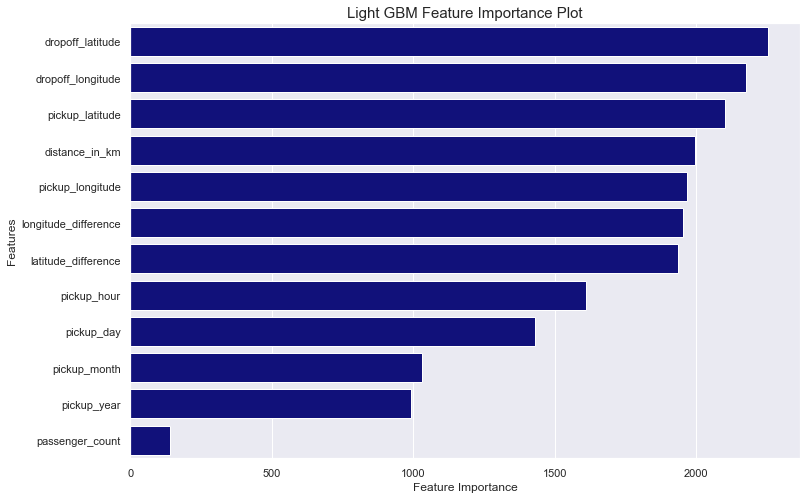

In [182]:
sns.set()
plt.figure(figsize=(12, 8))
sns.barplot(x=lightgb_feature_importance['Importance'],
            y=lightgb_feature_importance['Feature'], color='darkblue')
plt.title("Light GBM Feature Importance Plot", fontsize=15)
plt.xlabel('Feature Importance')
plt.ylabel('Features')

With GridSearch optimization on Light GBM regression, we have our best RMSE score with this dataset. 

<p>Potential Improvements: There are still couple things that we can work on to improve RMSE score for each model:<p/>

- We can fit more observations/ variables to improve models score. Since we have huge dataset and can't load whole dataset, we can work on reducing memory consumption.
- We can apply StandartScaler or any other Scaler to scale the dataset and re-run the models and check if the scores are improved.

# Conclusion

<p> This project includes complex models that predicts NYC cab fare amount with RMSE $ 3.37 . The project can easily be applied to a business model. We can create an app telling the customers how much their cab ride will be based on their location, time and passenger count.<p/>

<p>Based on our analysis:<p/>

- Most of the rides cost less than 25 dollars, average fare amount is $ 11.36.
- The least busy time of the day for the taxi cabs in NYC is 4 AM and 5 AM, the busiest time is between 6 PM to 7 PM.
- Most of the rides is with one passenger.
- The busiest season is Spring for NYC yellow cabs and the ride amounts hits the bottom in July and August.
- Average fare amount is increasing every year.

<p> Best RMSE scores with 4 algorithms:<p/>

- Linear Regression: 4.488
- Random Forest: 3.470
- Xgboost Regression: 3.371
- Light GBM Regression: 3.408